In [23]:
#VEGAS B
#Russell's Test Code 1
!pip install vegas

Defaulting to user installation because normal site-packages is not writeable


Generated 749149 accepted events out of 1000000 proposals.


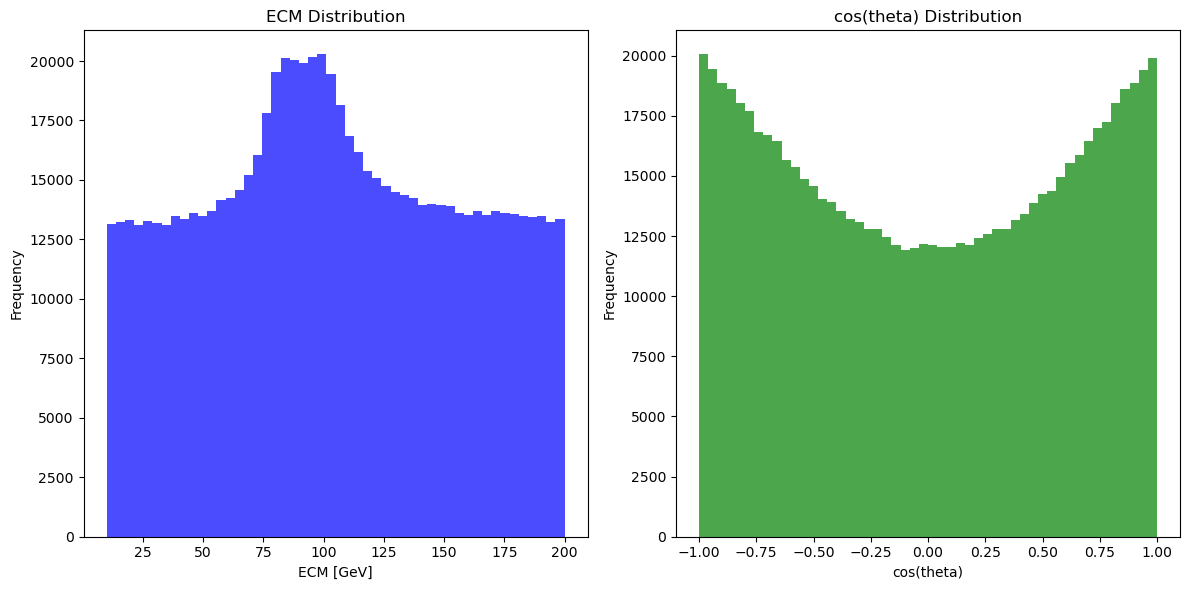

Generated 10000 events using adaptive VEGAS method of Monte Carlo integration with 10 iterations and 1000 evaluations per iteration.


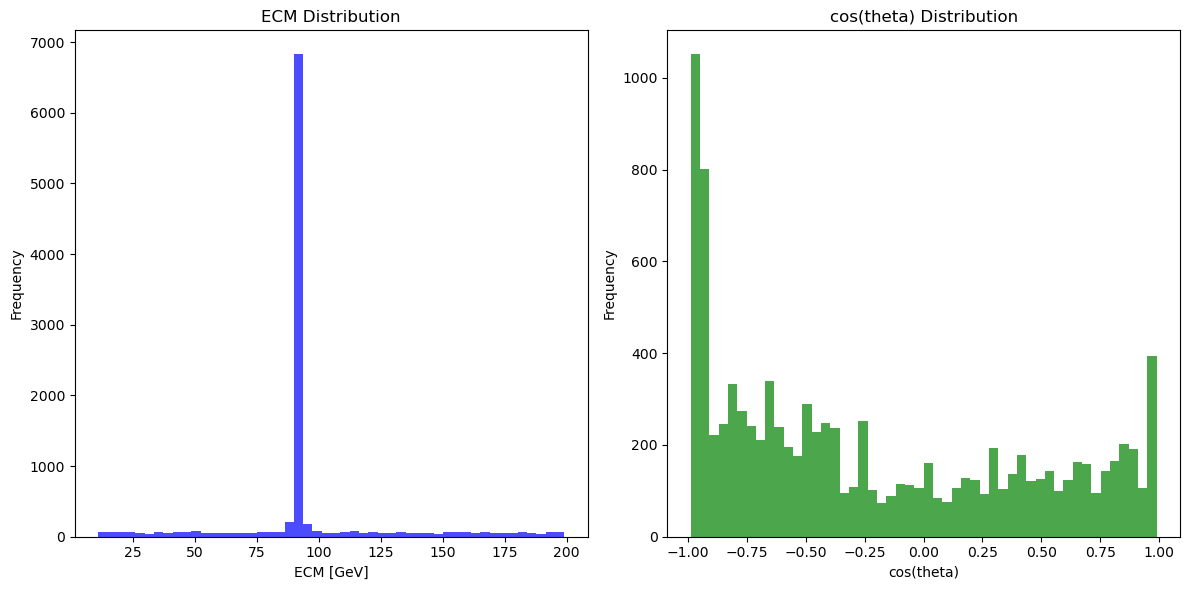

In [24]:
import numpy as np
import matplotlib.pyplot as plt
#cnsts from first table
M_Z = 91.188  #Z bosom mass GeV
Gamma_Z = 2.4414  #Z boson width GeV
alpha_EM = 1 / 132.507  #QED coupling
sin2_theta_W = 0.222246  #Weinberg angle
G_F = 1.16639e-5  #Fermi constant GeV^-2
kappa = np.sqrt(2 * G_F * M_Z**2) * M_Z**2 / (4 * np.pi) #derived from eq.9
#cnsts from 2nd table)
Q_f = -1
V_f = -0.5 + 2 * sin2_theta_W
A_f = -0.5
#def A0,A1 using eq.s 8-9
def chi_1(s):
    return kappa * s / ((s - M_Z**2)**2 + Gamma_Z**2 * M_Z**2)
def chi_2(s):
    return kappa * s * Gamma_Z**2 / ((s - M_Z**2)**2 + Gamma_Z**2 * M_Z**2)
def A0(s):
    return Q_f**2 - 2 * Q_f * V_f * chi_1(s) + (V_f**2 + A_f**2) * chi_1(s) + (V_f**2 + A_f**2) * chi_2(s)
def A1(s):
    return -4 * Q_f * A_f * chi_1(s) + 8 * A_f * V_f * chi_2(s)

def differential_cross_section(ecm, cos_theta): #eq. 7
    s = ecm**2
    ds_dOmega = (alpha_EM**2 / (48 * np.pi)) * (A0(s) * (1 + cos_theta**2) + A1(s) * cos_theta)
    return ds_dOmega

#Problem A: acceptance/rejection
def generate_drell_yan_events(num_samples, ecm_range=(10, 200), cos_range=(-1, 1)):
    ecm_min, ecm_max = ecm_range #integration ranges for ecm and costheta
    cos_min, cos_max = cos_range
    #random samples in ecm and costheta
    ecm_samples = np.random.uniform(ecm_min, ecm_max, num_samples)
    cos_samples = np.random.uniform(cos_min, cos_max, num_samples)
    #find different ds values, then find max for normalization
    ds_values = differential_cross_section(ecm_samples, cos_samples)
    max_ds_value = max(differential_cross_section(ecm_min, -1), differential_cross_section(ecm_max, 1))
    
    rand_vals = np.random.uniform(0, max_ds_value, num_samples)
    mask = rand_vals < ds_values #apply acceptance / rejection criterion w/ mask
    
    # Return accepted events as a numpy array
    return np.column_stack((ecm_samples[mask], cos_samples[mask]))
#visualization
def plot_distributions(events):
    ecm_values = events[:, 0]
    cos_values = events[:, 1]
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1) #ecm subplot
    plt.hist(ecm_values, bins=50, color='blue', alpha=0.7)
    plt.xlabel('ECM [GeV]')
    plt.ylabel('Frequency')
    plt.title('ECM Distribution')
    
    plt.subplot(1, 2, 2) #costheta subplot
    plt.hist(cos_values, bins=50, color='green', alpha=0.7)
    plt.xlabel('cos(theta)')
    plt.ylabel('Frequency')
    plt.title('cos(theta) Distribution')
    
    plt.tight_layout()
    plt.show()

#running acceptance/rejection for 1,000,000 samples
num_samples = int(1e6)  # Number of proposed samples
events = generate_drell_yan_events(num_samples)
print(f"Generated {len(events)} accepted events out of {num_samples} proposals.")
plot_distributions(events)

#problem B: VEGAS
def generate_drell_yan_events_adaptive(num_events, num_iterations=5, num_evaluations=1000, num_bins=100, damping=1.5, ecm_range=(10.0, 200.0), cos_range=(-1.0, 1.0)):
    ecm_min, ecm_max = ecm_range #integration ranges
    cos_min, cos_max = cos_range
    #initialize bins and weights
    ecm_bins = np.linspace(ecm_min, ecm_max, num_bins + 1)
    cos_bins = np.linspace(cos_min, cos_max, num_bins + 1)
    ecm_weights = np.ones(num_bins) / num_bins
    cos_weights = np.ones(num_bins) / num_bins

    events = [] #storage
    #grid adaptation iteration (this code weights bins, rather than changing their sizes)
    for iteration in range(num_iterations):
        ecm_integral_contributions = np.zeros(num_bins) #storing contributions
        cos_integral_contributions = np.zeros(num_bins)

        for _ in range(num_evaluations): #MC integrations
            #sample from current grid
            ecm = np.random.choice((ecm_bins[:-1] + ecm_bins[1:]) / 2, p=ecm_weights)
            cos_theta = np.random.choice((cos_bins[:-1] + cos_bins[1:]) / 2, p=cos_weights)
            #calculate ds and store events for each ecm, costheta
            ds = differential_cross_section(ecm, cos_theta)
            events.append([ecm, cos_theta])
            
            #bin assignment
            ecm_bin_index = np.digitize(ecm, ecm_bins) - 1
            cos_bin_index = np.digitize(cos_theta, cos_bins) - 1
            #check boundary before using index
            if 0 <= ecm_bin_index < num_bins:
                ecm_integral_contributions[ecm_bin_index] += ds
            if 0 <= cos_bin_index < num_bins:
                cos_integral_contributions[cos_bin_index] += ds
                
        #normalize, smooth, and renorm grid weights (must sum to 1)
        ecm_integral_contributions /= np.sum(ecm_integral_contributions)
        cos_integral_contributions /= np.sum(cos_integral_contributions)
        ecm_weights = (damping * ecm_weights + ecm_integral_contributions) / (damping + 1)
        cos_weights = (damping * cos_weights + cos_integral_contributions) / (damping + 1)
        ecm_weights /= np.sum(ecm_weights)
        cos_weights /= np.sum(cos_weights)
    return np.array(events)

#visualization is the same as before, still using plot_distribution(events)
#running
num_iterations = 10  #iterations per grid adaptation
num_evaluations = 1000  #evals per iteration
num_bins = 100 #bins for grid adaptation
damping = 1.5  #minimize rapid grid changes
#generate and plot
events = generate_drell_yan_events_adaptive(num_events, num_iterations, num_evaluations, num_bins, damping) 
print(f"Generated {len(events)} events using adaptive VEGAS method of Monte Carlo integration with {num_iterations} iterations and {num_evaluations} evaluations per iteration.")
plot_distributions(events)

